In [36]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
import matplotlib.style as style
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [37]:
videogame_df = pd.read_csv(r'C:\Users\USER\Desktop\Data_Science\DataScience project\Video_Games_Sales_as_at_22_Dec_2016.csv')

In [38]:
df = pd.get_dummies(videogame_df, prefix=['Genre'], columns=['Genre'], drop_first=True)

In [39]:
sales_list = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales']
top_20_pubs = videogame_df.groupby(['Publisher'
                              ])[sales_list].sum().sort_values(by='Global_Sales',
                                                               ascending=False).reset_index()['Publisher'].unique()[:20]

df = pd.get_dummies(videogame_df[videogame_df['Publisher'].isin(top_20_pubs)],
                    prefix=['Publ'], columns=['Publisher'], drop_first=True)

In [40]:
df = pd.get_dummies(videogame_df, prefix=['Plat'], columns=['Platform'], drop_first=True)


In [41]:
videogame_df.drop(['Rating', 'Name', 'Year_of_Release', 'Publisher', 'Platform'], axis='columns', inplace=True)


In [42]:
videogame_df.drop(['Developer'], axis='columns', inplace=True)
videogame_df.head()

,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
0,Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0
1,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN
2,Racing,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0
3,Sports,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0
4,Role-Playing,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN


In [43]:
videogame_df.dropna(inplace=True)

In [44]:
print('Check for missing values in the dataset: {}'.format(videogame_df.isnull().values.any()))

if videogame_df.isnull().values.any():
    old_size = len(videogame_df)

    videogame_df = videogame_df.dropna()

    new_size = len(videogame_df)

    print('\nNumber of Rows that were Removed: {:,}'.format(old_size - new_size))

Check for missing values in the dataset: False


In [45]:
from scipy import stats
before = videogame_df.shape[0]
print('Dataset size before outlier removal: {:,}'.format(before))

# Removes all records in the dataset that has data that is more than
# three standard deviations away from the mean of each column
videogame_df = videogame_df[(np.abs(stats.zscore(videogame_df[videogame_df.columns[1:]])) < 3).all(axis=1)].reset_index(drop=True)

after =videogame_df .shape[0]
print(' Dataset size after outlier removal: {:>6,}\n'.format(after) + '='*43 +
      '\n\t      Total records removed: {:>6,}'.format(before - after))

Dataset size before outlier removal: 7,017
 Dataset size after outlier removal:  6,582
	      Total records removed:    435


In [46]:
videogame_df = pd.get_dummies(videogame_df, prefix=['Genre'], columns=['Genre'], drop_first=True)
videogame_df.head()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,2.45,2.01,0.87,0.72,6.05,96.0,42.0,8.7,1026.0,False,False,False,False,False,False,False,False,False,False,False
1,3.18,1.83,0.78,0.24,6.03,94.0,20.0,9.4,918.0,False,False,False,False,False,False,False,False,False,False,False
2,3.07,1.91,0.07,0.57,5.63,67.0,35.0,7.2,21.0,False,False,False,False,False,False,False,False,True,False,False
3,2.54,1.93,0.21,0.86,5.55,91.0,70.0,8.6,1202.0,False,False,False,False,False,False,False,False,False,False,False
4,3.14,1.24,0.91,0.20,5.49,84.0,19.0,7.8,41.0,False,False,False,True,False,False,False,False,False,False,False


In [47]:
seed = 74 # Seed for train/test split and Model reproduction

x_train, x_test, y_train, y_test = train_test_split(videogame_df[videogame_df.columns.drop('Global_Sales')],
                                                    videogame_df['Global_Sales'],
                                                    train_size=0.70,
                                                    random_state=seed)

In [48]:
print("X_train Dimensions: {:,} columns and {:,} rows".format(x_train.shape[1], x_train.shape[0]))

x_train.head()

X_train Dimensions: 19 columns and 4,607 rows


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
4087,0.04,0.01,0.12,0.01,48.0,19.0,6.8,56.0,False,False,False,False,False,False,True,False,False,False,False
1865,0.54,0.00,0.00,0.04,81.0,20.0,7.3,25.0,False,False,False,False,False,False,False,False,False,True,False
5637,0.00,0.00,0.06,0.00,68.0,36.0,7.9,31.0,False,False,False,False,False,False,False,False,False,False,False
4390,0.11,0.00,0.04,0.01,53.0,30.0,6.8,6.0,False,False,False,False,False,False,False,False,False,False,False
5866,0.04,0.00,0.00,0.00,57.0,28.0,8.1,8.0,False,False,False,False,False,False,False,False,False,False,False


In [49]:
print("Describe Data: X_train")

x_train.describe()

Describe Data: X_train


,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,4607.000000,4607.000000,4607.000000,4607.000000,4607.000000,4607.000000,4607.000000,4607.000000
mean,0.294997,0.164975,0.035058,0.055249,70.209898,27.551552,7.247884,104.267853
std,0.424877,0.278534,0.104539,0.090119,12.909283,17.589851,1.302342,229.455330
min,0.000000,0.000000,0.000000,0.000000,29.000000,3.000000,2.900000,4.000000
25%,0.060000,0.020000,0.000000,0.010000,62.000000,14.000000,6.500000,11.000000
50%,0.140000,0.060000,0.000000,0.020000,72.000000,24.000000,7.500000,25.000000
75%,0.350000,0.180000,0.010000,0.060000,80.000000,38.000000,8.200000,77.000000
max,3.220000,2.230000,0.910000,0.860000,98.000000,86.000000,9.600000,1889.000000


In [50]:
print("Y_train Dimensions: 1 column and {:,} rows".format(y_train.shape[0]))

y_train.head()

Y_train Dimensions: 1 column and 4,607 rows


4087    0.18
1865    0.58
5637    0.06
4390    0.15
5866    0.05
Name: Global_Sales, dtype: float64

---------------------------------------------------------------

Multiple Linear Regression


In [51]:
from sklearn.linear_model import LinearRegression
regressor_MultiLinear = LinearRegression()
regressor_MultiLinear.fit(x_train,y_train)

LinearRegression()

In [52]:
## Predicting test results
y_pred_rm = regressor_MultiLinear.predict(x_test)

In [53]:
# Calculating r2 score
from sklearn.metrics import r2_score
r2_MultiLinear = r2_score(y_test,y_pred_rm)
print(r2_MultiLinear)

0.9999289342385467


In [54]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_rm)

print("Mean Squared Error:", mse)

Mean Squared Error: 3.544944254751914e-05


----------------------------------------------------------------------------------------------
Polynomial Regression

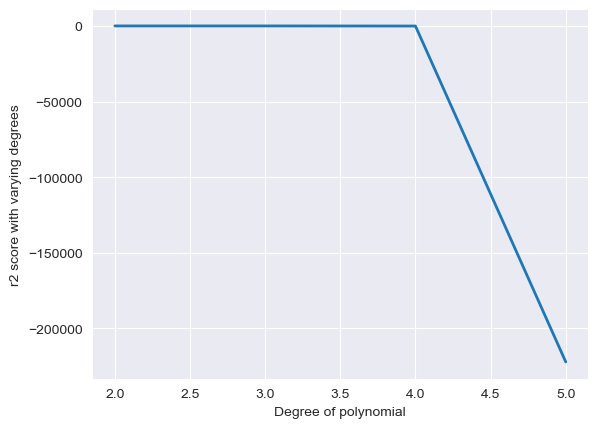

In [55]:
## Finding out the optimal degree of polynomial regression
from sklearn.preprocessing import PolynomialFeatures
sns.set_style('darkgrid')
scores_list = []
pRange = range(2,6)
for i in pRange :
    poly_reg = PolynomialFeatures(degree=i)
    x_poly = poly_reg.fit_transform(x_train)
    poly_regressor = LinearRegression()
    poly_regressor.fit(x_poly,y_train)
    y_pred = poly_regressor.predict(poly_reg.fit_transform(x_test))
    scores_list.append(r2_score(y_test,y_pred))
plt.plot(pRange,scores_list,linewidth=2)
plt.xlabel('Degree of polynomial')
plt.ylabel('r2 score with varying degrees')
plt.show()

In [56]:
## Training the polynomial regression on the training model
poly_reg = PolynomialFeatures(degree=2)
x_poly = poly_reg.fit_transform(x_train)
poly_regressor = LinearRegression()
poly_regressor.fit(x_poly,y_train)
y_pred_pr = poly_regressor.predict(poly_reg.fit_transform(x_test))
r2_poly = r2_score(y_test,y_pred_pr)
print(r2_poly)

0.9999263152086475


In [57]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_pr)

print("Mean Squared Error:", mse)

Mean Squared Error: 3.675588249894931e-05


--------------------------------------------------------------------------------------------
DecisionTree Regression

In [58]:
from sklearn.tree import DecisionTreeRegressor
regressor_Tree = DecisionTreeRegressor(random_state=0)
regressor_Tree.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

In [59]:
y_pred_Dt = regressor_Tree.predict(x_test)

In [75]:
# Calculating r2 score
r2_tree = r2_score(y_test,y_pred_Dt)
print(r2_tree)

0.9834852708068936


In [61]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_Dt)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.008237974683544303


-----------------------------------------------------------------
Random Forest Regression

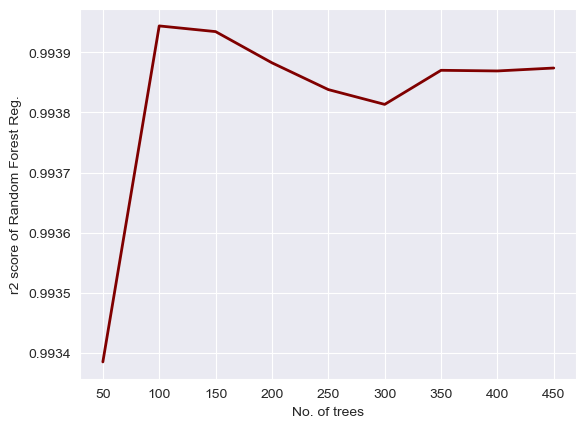

In [62]:
# Finding out the optimal number of trees for Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
forestRange=range(50,500,50)
scores_list=[]
for i in forestRange: 
    regressor_Forest = RandomForestRegressor(n_estimators=i,random_state=0)
    regressor_Forest.fit(x_train,y_train)
    y_pred = regressor_Forest.predict(x_test)
    scores_list.append(r2_score(y_test,y_pred))
plt.plot(forestRange,scores_list,linewidth=2,color='maroon')
plt.xticks(forestRange)
plt.xlabel('No. of trees')
plt.ylabel('r2 score of Random Forest Reg.')
plt.show()    

In [63]:
# Training the Random Forest regression on the training model
regressor_Forest = RandomForestRegressor(n_estimators=100,random_state=0)
regressor_Forest.fit(x_train,y_train)
y_pred = regressor_Forest.predict(x_test)
r2_forest = r2_score(y_test,y_pred)
print(r2_forest)

0.9939440006919092


In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.0030208893164556955


------------------------------------------------------------
Linear Support Vector Regression

In [65]:
## Training the Linear SVR model on the training set
from sklearn.svm import SVR
regressor_SVR = SVR(kernel='linear')
regressor_SVR.fit(x_train,y_train)

SVR(kernel='linear')

In [66]:
## Predicting test results
y_pred_svr = regressor_SVR.predict(x_test)

In [67]:
from sklearn.metrics import r2_score
## Calculating r2 score
r2_linearSVR = r2_score(y_test,y_pred_svr)
print(r2_linearSVR)

0.9992943517792043


In [68]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_svr)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.00035199561012659423


xg boost

In [69]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [70]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
xgb_regressor.fit(x_train, y_train)





XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [71]:
# Make predictions on the testing data
y_pred_xgb = xgb_regressor.predict(x_test)


In [72]:
from sklearn.metrics import r2_score
## Calculating r2 score
r2_xgb = r2_score(y_test,y_pred_xgb)
print(r2_linearSVR)

0.9992943517792043


In [73]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_xgb)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.00208779165976049


-------------------------------------------------------------------

In [76]:
## Comparing the r2 scores of different models
labelList = ['Multiple Linear Reg.','Polynomial Reg.','Decision Tree','Random Forest',
             'Linear SVR','XGBoost']
mylist = [r2_MultiLinear,r2_poly,r2_tree,r2_forest,r2_linearSVR,r2_xgb]
for i in range(0,len(mylist)):
    mylist[i]=np.round(mylist[i]*100,decimals=3)
print(mylist)

[99.993, 99.993, 98.349, 99.394, 99.929, 99.581]


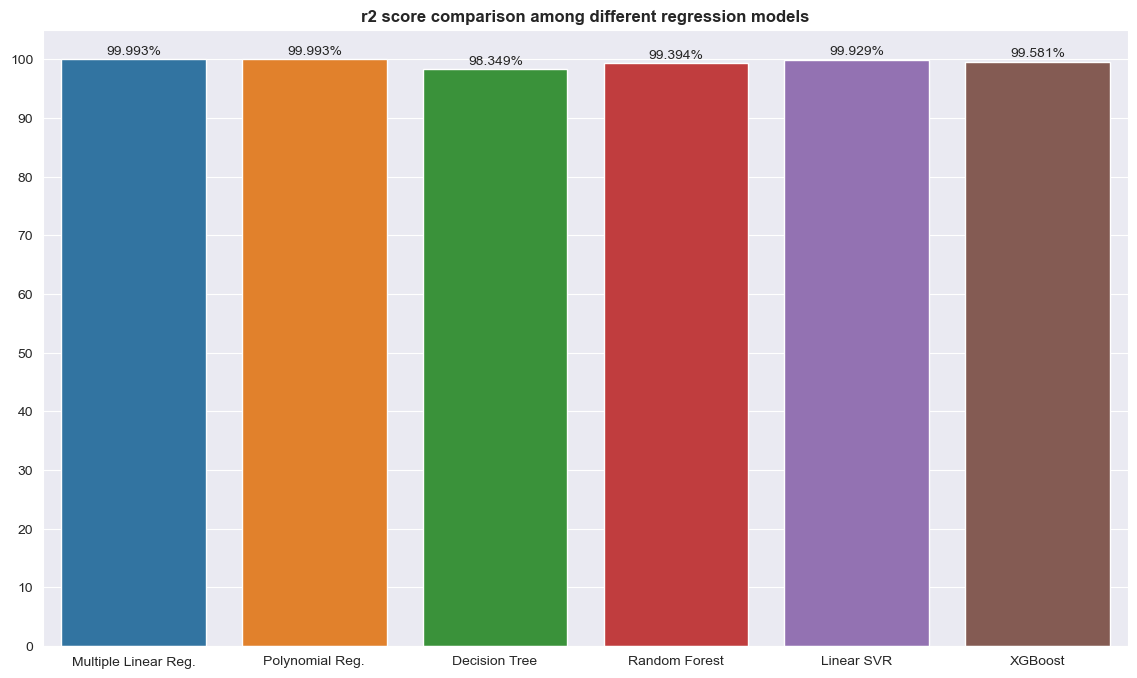

In [77]:
plt.figure(figsize=(14,8))
ax = sns.barplot(x=labelList,y=mylist)
plt.yticks(np.arange(0, 101, step=10))
plt.title('r2 score comparison among different regression models',fontweight='bold')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.3f}%'.format(height), (x +0.25, y + height + 0.8))
plt.show()